In [1]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import tensorflow as tf
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import initializers
from keras.layers import Dropout, Activation, Embedding, Convolution1D, MaxPooling1D, Input, Dense, add, \
                         BatchNormalization, Flatten, Reshape, LSTM, GRU
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
news= pd.read_csv("News.csv")
stock_data= pd.read_csv("DowJones.csv")
print(news.head())
stock_data.head()

         Date                                               News
0  2016-07-01  A 117-year-old woman in Mexico City finally re...
1  2016-07-01   IMF chief backs Athens as permanent Olympic host
2  2016-07-01  The president of France says if Brexit won, so...
3  2016-07-01  British Man Who Must Give Police 24 Hours' Not...
4  2016-07-01  100+ Nobel laureates urge Greenpeace to stop o...


,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


1. find a correlated varible between the joins of sentiment dataset and the stock dataset
2. try to try the most common keywords/tokens that seem to impact the regression 
3. reduce the number of features in the collective merged_df into 1 or 2 different columns and build a classification or NN type of an algorithm to observe how our variables interact

In [3]:
print("stock data shape:", stock_data.shape)
print("News shape:", news.shape)

stock data shape: (1989, 7)
News shape: (73608, 2)


In [4]:
stock_first_date = stock_data['Date'].min()
stock_last_date = stock_data['Date'].max()

print("First date in stock data:", stock_first_date)
print("Last date in stock data:", stock_last_date)


First date in stock data: 2008-08-08
Last date in stock data: 2016-07-01


In [5]:
news_first_date = news['Date'].min()
news_last_date = news['Date'].max()

print("First date in news data:", news_first_date)
print("Last date in news data:", news_last_date)


First date in news data: 2008-06-08
Last date in news data: 2016-07-01


In [6]:
stock_unique_dates_count = stock_data['Date'].nunique()
news_unique_dates_count = news['Date'].nunique()

print("unique dates in stock data:",stock_unique_dates_count)
print("unique dates in news data:",news_unique_dates_count)

unique dates in stock data: 1989
unique dates in news data: 2943


In [7]:
print(news.isnull().sum())
print(stock_data.isnull().sum())

Date    0
News    0
dtype: int64
Date         0
Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64


In [8]:
merged_df = news.merge(stock_data[['Date']], on='Date', how='inner')
news = merged_df.drop_duplicates(subset='Date', keep='first')
print(news.shape)
print(stock_data.shape)

(1989, 2)
(1989, 7)


In [9]:
# Assuming 'Date' is the common column in both datasets

# Merge the two datasets on the 'Date' column
merged_df = pd.merge(stock_data, news, on='Date', how='inner')

# Display the merged dataframe
merged_df.head()


,Date,Open,High,Low,Close,Volume,Adj Close,News
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141,A 117-year-old woman in Mexico City finally re...
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234,Jamaica proposes marijuana dispensers for tour...
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688,Explosion At Airport In Istanbul
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703,"2,500 Scientists To Australia: If You Want To ..."
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234,Barclays and RBS shares suspended from trading...


In [10]:
merged_df.shape

(1989, 8)

In [11]:
# Compute the number of headlines for each day
merged_df['Num_Headlines'] = merged_df['News'].apply(len)

# Maximum number of headlines for a day
max_headlines = merged_df['Num_Headlines'].max()

# Minimum number of headlines for a day
min_headlines = merged_df['Num_Headlines'].min()

# Mean number of headlines for a day
mean_headlines = merged_df['Num_Headlines'].mean()

print("Maximum number of headlines for a day:", max_headlines)
print("Minimum number of headlines for a day:", min_headlines)
print("Mean number of headlines for a day:", mean_headlines)


Maximum number of headlines for a day: 304
Minimum number of headlines for a day: 17
Mean number of headlines for a day: 121.27501256913021


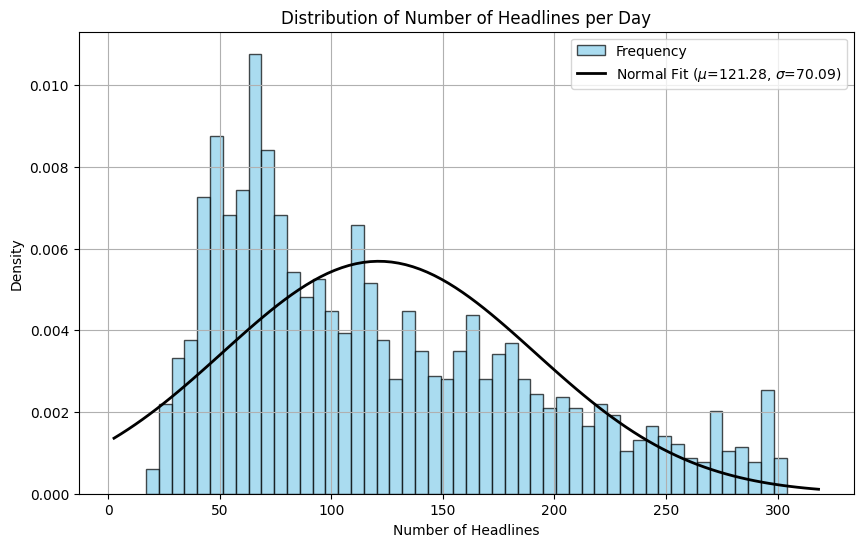

In [12]:
from scipy.stats import norm

# Compute the number of headlines for each day
merged_df['Num_Headlines'] = merged_df['News'].apply(len)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(merged_df['Num_Headlines'], bins=50, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Frequency')

# Fit a normal distribution to the data
mu, std = norm.fit(merged_df['Num_Headlines'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label=f'Normal Fit ($\mu$={mu:.2f}, $\sigma$={std:.2f})')

plt.title('Distribution of Number of Headlines per Day')
plt.xlabel('Number of Headlines')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# A list of contractions from stackoverflow.com
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [14]:
# Apply the clean_text function to the 'News' column
import re
from nltk.corpus import stopwords

def clean_text(text, remove_stopwords=True):


    # Convert words to lowercase
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'0,0', '00', text) 
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'u s ', ' united states ', text)
    text = re.sub(r'u n ', ' united nations ', text)
    text = re.sub(r'u k ', ' united kingdom ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)
    
    # remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

# Apply the clean_text function to the 'News' column
merged_df['Cleaned_News'] = merged_df['News'].apply(clean_text)



In [15]:
merged_df["Cleaned_News"].head()

0    117 year old woman mexico city finally receive...
1    jamaica proposes marijuana dispensers tourists...
2                           explosion airport istanbul
3    2 500 scientists australia want save great bar...
4      barclays rbs shares suspended trading tanking 8
Name: Cleaned_News, dtype: object

In [16]:
# # Initialize an empty dictionary to store word counts
# word_counts = {}

# # Iterate through each row in the 'Cleaned_News' column
# for headline_list in merged_df['Cleaned_News']:
#     for headline in headline_list:
#         # Split the headline into words
#         words = headline.split()
#         # Update word counts dictionary
#         for word in words:
#             if word not in word_counts:
#                 word_counts[word] = 1
#             else:
#                 word_counts[word] += 1

# # Print the size of the vocabulary
# print("Size of Vocabulary:", len(word_counts))
# print(word_counts)
# Initialize an empty dictionary to store word counts
word_counts = {}

# Iterate over each cleaned headline
for date in merged_df['Cleaned_News']:
    for headline in date:
        # Tokenize the headline into words
        words = headline.split()
        # Iterate over each word in the headline
        for word in words:
            # Update the word count dictionary
            if word not in word_counts:
                word_counts[word] = 1
            else:
                word_counts[word] += 1

# Sort the word counts dictionary by frequency in descending order
word_counts_sorted = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Print the size of the vocabulary
print("Size of Vocabulary:", len(word_counts))

# Print the top 10 most frequent words and their counts
print("Top 10 Most Frequent Words:")
for word, count in word_counts_sorted[:10]:
    print(word, "-", count)



Size of Vocabulary: 40
Top 10 Most Frequent Words:
e - 18068
a - 13804
i - 13012
s - 12105
n - 11648
r - 11526
t - 10551
o - 9658
l - 7807
d - 6457


In [17]:
# embeddings_index = {}
# with open('C:/Users/HP/Desktop/glove.840B.300d.txt', encoding='utf-8') as f:
#     for line in f:
#         values = line.split(' ')
#         word = values[0]
#         embedding = np.asarray(values[1:], dtype='float32')
#         embeddings_index[word] = embedding

# print('Word embeddings:', len(embeddings_index))

In [18]:
merged_df['Growth/Decay'] = merged_df['Adj Close'] - merged_df['Open']
merged_df.head()

,Date,Open,High,Low,Close,Volume,Adj Close,News,Num_Headlines,Cleaned_News,Growth/Decay
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141,A 117-year-old woman in Mexico City finally re...,184,117 year old woman mexico city finally receive...,25.128907
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234,Jamaica proposes marijuana dispensers for tour...,199,jamaica proposes marijuana dispensers tourists...,217.230468
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688,Explosion At Airport In Istanbul,32,explosion airport istanbul,238.660157
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703,"2,500 Scientists To Australia: If You Want To ...",95,2 500 scientists australia want save great bar...,219.210937
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234,Barclays and RBS shares suspended from trading...,73,barclays rbs shares suspended trading tanking 8,-214.970704


In [19]:
sentiment_scores = []
for headline in merged_df['News']:
    # Perform sentiment analysis on each headline
    blob = TextBlob(headline)
    sentiment_scores.append(blob.sentiment.polarity)

# Step 3: Combine data
merged_df['Sentiment'] = sentiment_scores
merged_df['Sentiment'].head()

0   -0.066667
1    0.000000
2    0.000000
3    0.525000
4    0.500000
Name: Sentiment, dtype: float64

In [20]:
print(merged_df['Sentiment'].min())
print(merged_df["Sentiment"].max())

-1.0
1.0


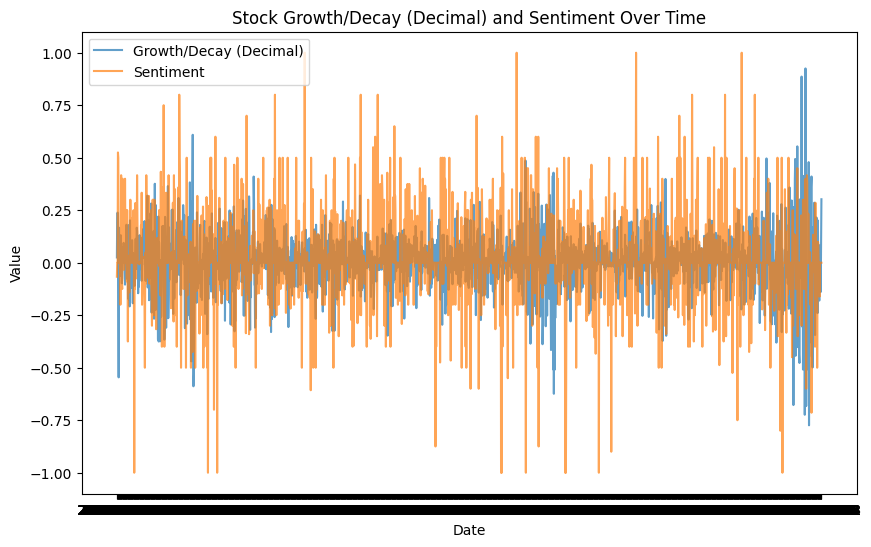

In [21]:
merged_df['Growth/Decay'] = merged_df['Growth/Decay'] / 1000

# Plotting with transparency
plt.figure(figsize=(10, 6))
plt.plot(merged_df['Date'], merged_df['Growth/Decay'], label='Growth/Decay (Decimal)', alpha=0.7)  # Adjust alpha value as needed
plt.plot(merged_df['Date'], merged_df['Sentiment'], label='Sentiment', alpha=0.7)  # Adjust alpha value as needed
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Stock Growth/Decay (Decimal) and Sentiment Over Time')
plt.legend()
plt.show()

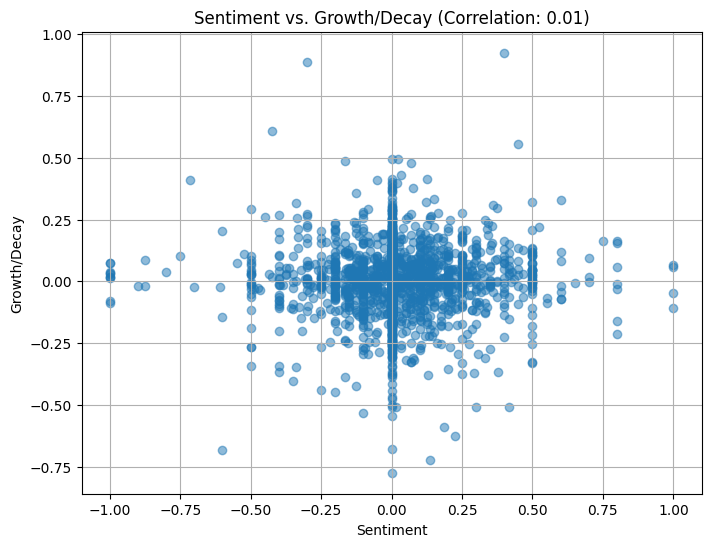

In [22]:
correlation = np.corrcoef(merged_df['Sentiment'], merged_df['Growth/Decay'])[0, 1]

# Plotting the correlation chart
plt.figure(figsize=(8, 6))
plt.scatter(merged_df['Sentiment'], merged_df['Growth/Decay'], alpha=0.5)
plt.title(f"Sentiment vs. Growth/Decay (Correlation: {correlation:.2f})")
plt.xlabel('Sentiment')
plt.ylabel('Growth/Decay')
plt.grid(True)
plt.show()

In [23]:
sentiment_variance = merged_df['Sentiment'].var()

# Check the variance of the 'Growth/Decay' column
growth_decay_variance = merged_df['Growth/Decay'].var()

# Print the results
print("Variance of Sentiment column:", sentiment_variance)
print("Variance of Growth/Decay column:", growth_decay_variance)


Variance of Sentiment column: 0.045258390148369985
Variance of Growth/Decay column: 0.0199453304502619


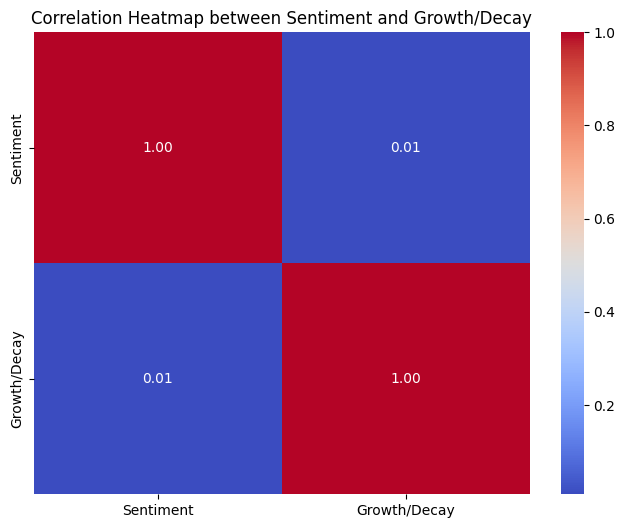

In [24]:
import seaborn as sns

correlation_matrix = merged_df[['Sentiment', 'Growth/Decay']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap between Sentiment and Growth/Decay')
plt.show()

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

X = merged_df['Sentiment'].values.reshape(-1, 1)  # Features (sentiment scores)
y = merged_df['Growth/Decay'].values  # Target variable (growth/decay values)

# Step 2: Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Choose a Model
model = LinearRegression()

# Step 4: Train the Model
model.fit(X_train, y_train)

# Step 5: Evaluate the Model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.09886918245446068


In [26]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)  # Ensure that mse is a numerical value, not a function
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Squared Error (MSE): 0.02030942562379107
Root Mean Squared Error (RMSE): 0.1425111421040161
